In [1]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log
17,application_1613335206545_0015,pyspark,idle,Link,Link


SparkSession available as 'spark'.

## Import modules

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, LongType
from pyspark.sql.functions import explode
import hsfs

In [3]:
import hsfs
# Create a connection
connection = hsfs.connection()
# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

In [4]:
def prep_alert_for_ploting(alert_id):
    demo_alert = alert_transactions_df.where(F.col("alert_id")==alert_id).select("src","dst","tran_timestamp", "base_amt")
    demo_nodes = party_df.join(
        demo_alert,
        [(party_df.id==demo_alert.src)|(party_df.id==demo_alert.dst)],
        how="inner"
    ).dropDuplicates(subset=['id']).drop(*["src", "dst", "tran_timestamp"])
    return demo_nodes, demo_alert

In [5]:
alert_transactions_fg = fs.get_feature_group("alert_transactions_fg",1)
alert_transactions_fg.show(5)

+--------------+------+-------+--------+
|    alert_type|is_sar|tran_id|alert_id|
+--------------+------+-------+--------+
|gather_scatter|  true|  11873|      47|
|gather_scatter|  true|  11874|      47|
|gather_scatter|  true|  11875|      47|
|gather_scatter|  true|  13151|      47|
|gather_scatter|  true|  23148|      47|
+--------------+------+-------+--------+
only showing top 5 rows

In [6]:
transactions_fg = fs.get_feature_group("transactions_fg",1)
transactions_fg.show(5)

+--------+-------+--------------+-------+--------+--------+
|     dst|tran_id|tran_timestamp|tx_type|     src|base_amt|
+--------+-------+--------------+-------+--------+--------+
|1e46e726|    496|        Jan-01|      4|3aa9646b|  858.77|
|a74d1101|   1342|        Jan-01|      4|49203bc3|  386.86|
|99af2455|   1580|        Jan-02|      4|616d4505|  616.43|
|e7ec7bdb|   2866|        Jan-02|      4|39be1ea2|  146.44|
|afc399a9|   3997|        Jan-03|      4|e2e0d938|  439.09|
+--------+-------+--------------+-------+--------+--------+
only showing top 5 rows

In [7]:
party_df = fs.get_feature_group("party_fg",1).read()
party_df.show(5)

+--------+----+
|      id|type|
+--------+----+
|5628bd6c|   0|
|a1fcba39|   0|
|f56c9501|   1|
|9969afdd|   0|
|b356eeae|   1|
+--------+----+
only showing top 5 rows

In [8]:
alert_transactions_df = alert_transactions_fg.select(["alert_type", "tran_id", "alert_id"])\
                                             .join(transactions_fg.select_all(),["tran_id"],"inner")\
                                             .read()

In [9]:
alert_transactions_df.groupBy("alert_type").agg(F.count("alert_type")).show()

+--------------+-----------------+
|    alert_type|count(alert_type)|
+--------------+-----------------+
|gather_scatter|              272|
|         cycle|              235|
|scatter_gather|              408|
+--------------+-----------------+

In [10]:
alert_transactions_df.where(F.col("alert_type")=="cycle").show()

+----------+-------+--------+--------+-------+--------------+-------+--------+--------+
|alert_type|tran_id|alert_id|     dst|tran_id|tran_timestamp|tx_type|     src|base_amt|
+----------+-------+--------+--------+-------+--------------+-------+--------+--------+
|     cycle| 811151|      88|e6c76032| 811151|        Jul-21|      4|b0fe7e18|  112.19|
|     cycle| 864390|      71|2a348960| 864390|        Aug-27|      4|5a89d195|  107.84|
|     cycle| 137352|      94|0c81ba35| 137352|        Apr-06|      4|4c52d76b|   94.95|
|     cycle| 856332|      99|19857dba| 856332|        Aug-21|      4|edfe718c|   103.5|
|     cycle| 248494|      82|11d52a92| 248494|        Jun-22|      4|208d7af9|   66.64|
|     cycle| 980285|      95|6d9d3784| 980285|        Nov-16|      4|9cf31a21|  129.78|
|     cycle| 721517|      91|d0ba8246| 721517|        May-19|      4|308d1047|   92.67|
|     cycle| 103476|      75|16fcc326| 103476|        Mar-13|      4|bbc48e4b|   73.36|
|     cycle| 654498|      98|95a

In [11]:
#gather_scatter
demo_nodes, demo_alert = prep_alert_for_ploting(alert_id="58")

In [12]:
%%spark -o demo_nodes

In [13]:
%%spark -o demo_alert

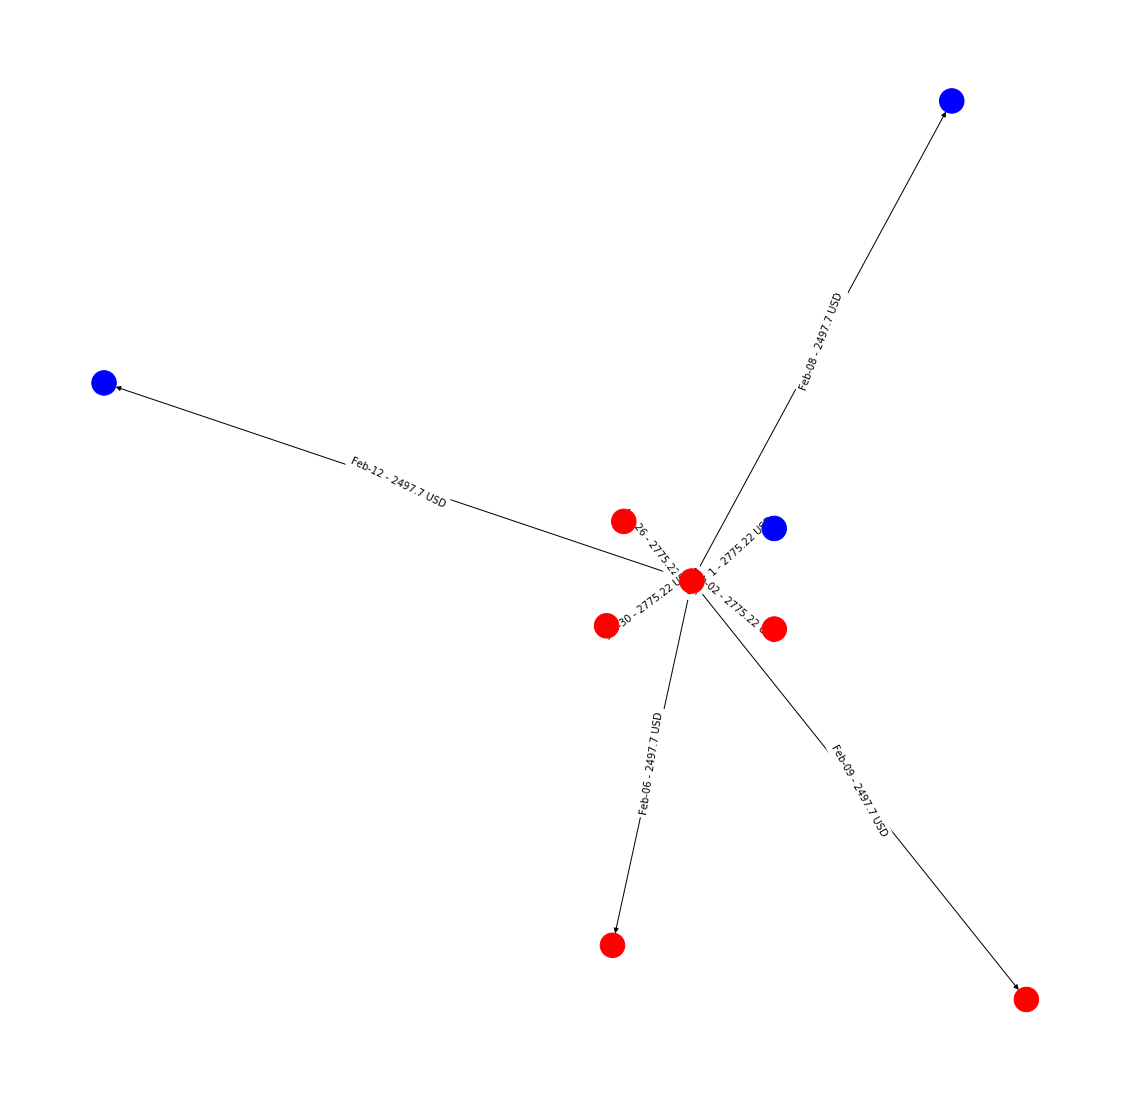

In [14]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
#e.head()
G = nx.from_pandas_edgelist(demo_alert,source='src',
                                   target='dst',edge_attr=True,
                                   create_using=nx.DiGraph())

demo_nodes = demo_nodes[(demo_nodes["type"]==0)]
organization_list = demo_nodes['id'].tolist()

val_map = {}
values = [val_map.get(node, 600) for node in G.nodes()]

edge_labels=dict([((u,v,),d['tran_timestamp'] + " - " + str(d['base_amt']) + ' USD') for u,v,d in G.edges(data=True)])
node_colors = ['blue' if not node in organization_list else 'red' for node in G.nodes()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=values, edge_color='black',edge_cmap=plt.cm.Reds, node_color = node_colors) #, with_labels = True
plt.show()

In [15]:
demo_alert.head()

Row(src='72555c71', dst='6c344249', tran_timestamp='Jan-26', base_amt=2775.22)

In [16]:
# scatter_gather
demo_nodes, demo_alert = prep_alert_for_ploting(alert_id="20")

In [17]:
%%spark -o demo_nodes

In [18]:
%%spark -o demo_alert

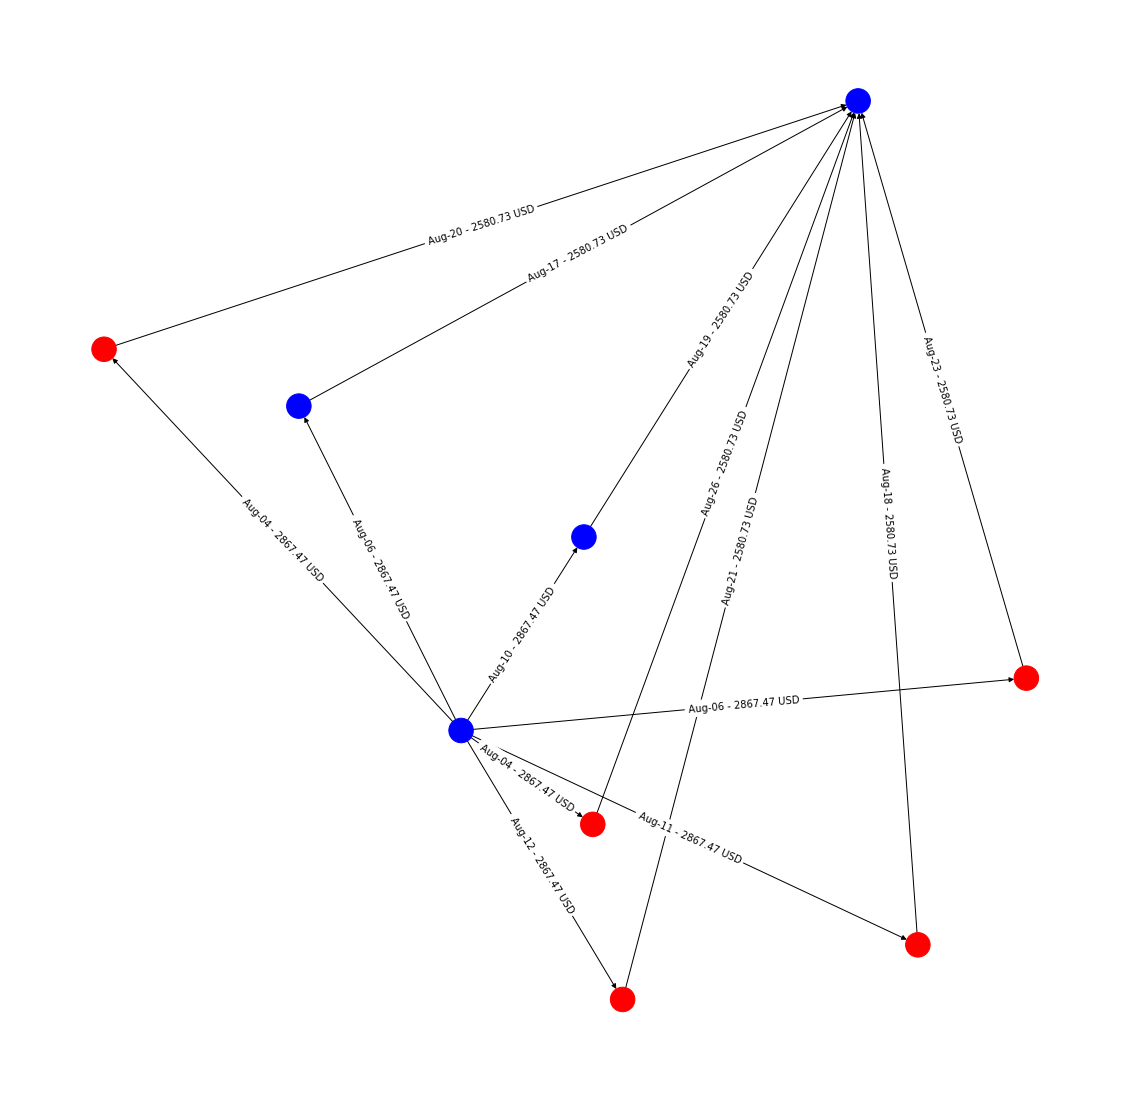

In [19]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
#e.head()
G = nx.from_pandas_edgelist(demo_alert,source='src',
                                   target='dst',edge_attr=True,
                                   create_using=nx.DiGraph())

demo_nodes = demo_nodes[(demo_nodes["type"]==0)]
organization_list = demo_nodes['id'].tolist()

val_map = {}
values = [val_map.get(node, 600) for node in G.nodes()]

edge_labels=dict([((u,v,),d['tran_timestamp'] + " - " + str(d['base_amt']) + ' USD') for u,v,d in G.edges(data=True)])
node_colors = ['blue' if not node in organization_list else 'red' for node in G.nodes()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=values, edge_color='black',edge_cmap=plt.cm.Reds, node_color = node_colors) #, with_labels = True
plt.show()

In [20]:
#cycle
demo_nodes, demo_alert = prep_alert_for_ploting(alert_id="71")

In [21]:
%%spark -o demo_nodes

In [22]:
%%spark -o demo_alert

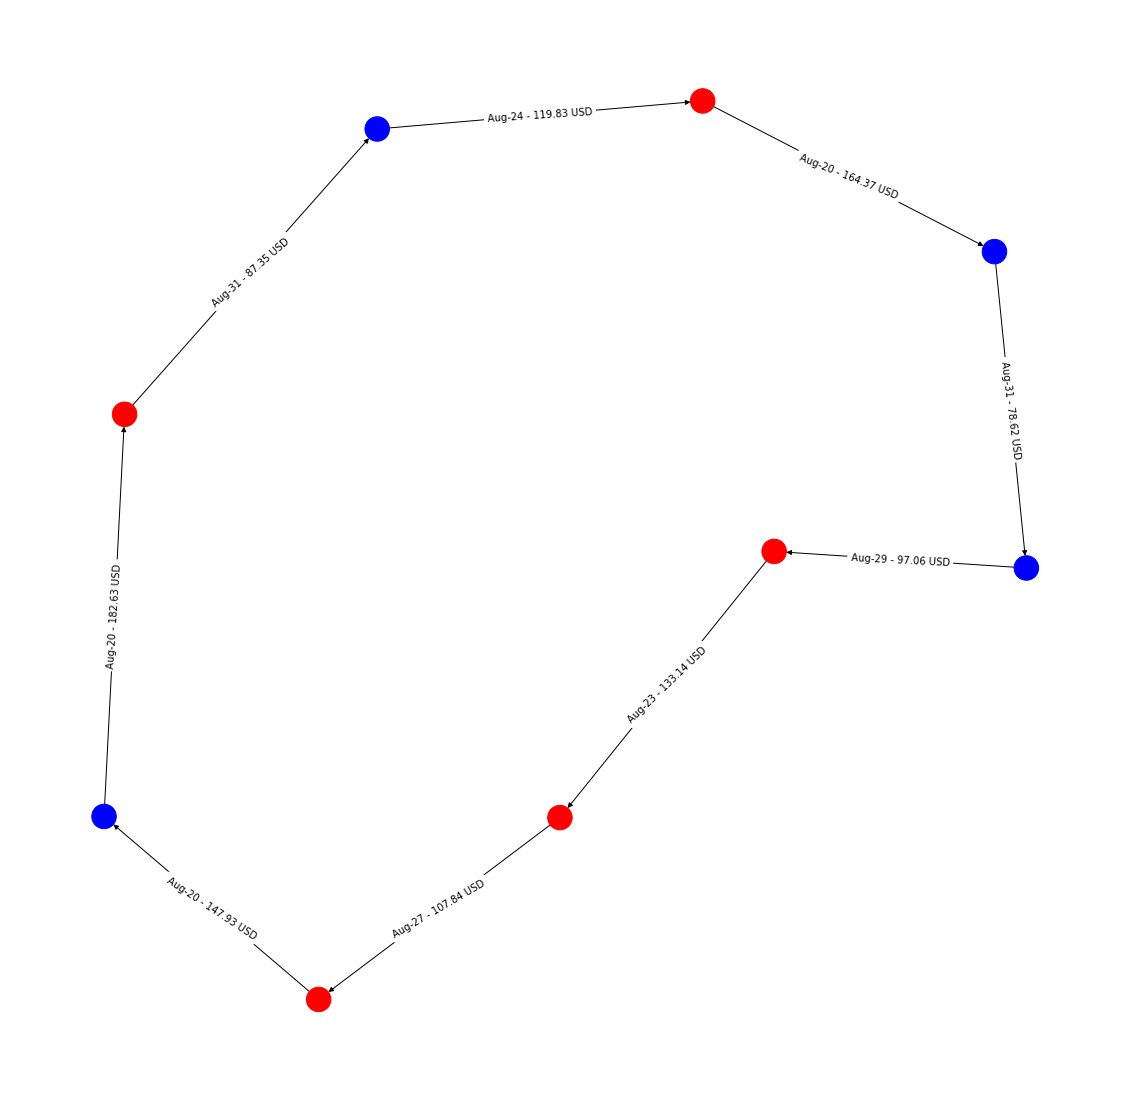

In [25]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
#e.head()
G = nx.from_pandas_edgelist(demo_alert,source='src',
                                   target='dst',edge_attr=True,
                                   create_using=nx.DiGraph())

demo_nodes = demo_nodes[(demo_nodes["type"]==0)]
organization_list = demo_nodes['id'].tolist()

val_map = {}
values = [val_map.get(node, 600) for node in G.nodes()]

edge_labels=dict([((u,v,),d['tran_timestamp'] + " - " + str(d['base_amt']) + ' USD') for u,v,d in G.edges(data=True)])
node_colors = ['blue' if not node in organization_list else 'red' for node in G.nodes()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=values, edge_color='black',edge_cmap=plt.cm.Reds, node_color = node_colors) #, with_labels = True
plt.show()